Arwa Ahmed Mostafa Shazly (221100209)

Section Three: clustering-based CF

Part 1 --> K-means clustering based in average number of user ratings

1.Load ru from section 1

In [1]:
import pandas as pd
import numpy as np
ratings_stats = pd.read_csv("ratings_statistics.csv")

2.Create 1-D feature vector

In [2]:
user_feature_vector = ratings_stats.groupby('userId')['ru'].mean().reset_index()
user_feature_vector.rename(columns={'ru': 'feature'}, inplace=True)
print(user_feature_vector.head(10))

   userId   feature
0       1  3.942857
1       2  4.000000
2       3  4.122995
3       4  3.571429
4       5  4.272727
5       6  3.750000
6       7  3.289855
7       8  3.800000
8       9  3.057143
9      10  3.894737


3.calculate the mean of user's average ratings μ (Mu)

In [3]:
N= len(user_feature_vector)
mean_ru = user_feature_vector['feature'].sum() / N
print(f"Mean of users' average ratings: {mean_ru:.4f}")

Mean of users' average ratings: 3.6271


4.compute the standard deviation of users’ average ratings σ (Sigma)

In [4]:
squared_difference = ((user_feature_vector['feature'] - mean_ru) ** 2).sum()
std_ru = (squared_difference / len(user_feature_vector)) ** 0.5
print(f"Standard deviation of users'a average ratings: {std_ru:.4f}")

Standard deviation of users'a average ratings: 0.4232


5. Z-score Normalization

In [5]:
user_feature_vector['z_score'] = (user_feature_vector['feature'] - mean_ru) / std_ru
print(user_feature_vector.head(10))

   userId   feature   z_score
0       1  3.942857  0.746057
1       2  4.000000  0.881068
2       3  4.122995  1.171669
3       4  3.571429 -0.131521
4       5  4.272727  1.525444
5       6  3.750000  0.290391
6       7  3.289855 -0.796797
7       8  3.800000  0.408527
8       9  3.057143 -1.346628
9      10  3.894737  0.632362


I've checked the first 5 z-scores manually to ensure the upcoming calculation is correct

6.Apply k-means clusteirng with different k values

       6.1 Applying K means

In [6]:
def kmeans(features, k, max_iters=100, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    n_samples = features.shape[0]
    # Step 1: Initialize centroids randomly from the data points
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = features[random_indices].copy()
    for iteration in range(max_iters):
        # Step 2: Assign each point to nearest centroid
        # Calculate distances from each point to each centroid
        distances = np.zeros((n_samples, k))
        for i in range(k):
            # Euclidean distance
            distances[:, i] = np.sqrt(np.sum((features - centroids[i])**2, axis=1))
        
        # Assign to nearest centroid
        labels = np.argmin(distances, axis=1)
        
        # Step 3: Update centroids
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = features[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                # If cluster is empty, reinitialize to random point as the new centroid
                new_centroids[i] = features[np.random.choice(n_samples)]
        
        # Step 4: Check for convergence
        centroid_shift = np.sqrt(np.sum((new_centroids - centroids)**2))
        centroids = new_centroids
        if centroid_shift < tol:
            print(f"  Converged at iteration {iteration + 1}")
            break
    
    # Calculate sum of squared distances to nearest centroid
    inertia = 0
    for i in range(n_samples):
        inertia += np.sum((features[i] - centroids[labels[i]])**2)
    return centroids, labels, inertia

features = user_feature_vector[['z_score']].values

In [7]:
# Test different k values 
k_values = [5, 10, 15, 20, 30, 50]
results = {}

for k in k_values:
    # use the K-Means
    centroids, labels, inertia = kmeans(features, k, max_iters=100, random_state=42)
    
    # Store the results
    results[k] = {
        'centroids': centroids,  # k cluster centroids
        'labels': labels,       
        'inertia': inertia       # sum of squared distances
    }
    
    avg_cluster_size = len(labels) / k
    print(f"K={k} | Inertia={inertia:.4f} , Avg Cluster Size={avg_cluster_size:.1f}")


  Converged at iteration 47
K=5 | Inertia=13474.5674 , Avg Cluster Size=27698.6
  Converged at iteration 83
K=10 | Inertia=3989.6629 , Avg Cluster Size=13849.3
K=15 | Inertia=1875.1704 , Avg Cluster Size=9232.9
  Converged at iteration 93
K=20 | Inertia=1193.3144 , Avg Cluster Size=6924.6
K=30 | Inertia=644.4821 , Avg Cluster Size=4616.4
K=50 | Inertia=349.8526 , Avg Cluster Size=2769.9


In [8]:
k_best = 5 
user_centroids = results[k_best]['centroids']     # shape (k_best, 1) for z_score
user_labels    = results[k_best]['labels']        # cluster index for each row in user_feature_vector
print("User centroids shape:", user_centroids.shape)
print("First few centroids:\n", user_centroids[:5])


User centroids shape: (5, 1)
First few centroids:
 [[-2.48413783]
 [ 0.56202614]
 [-0.19591777]
 [ 1.44474666]
 [-1.06393343]]


         6.2 Assigning user to each cluster depending on the k

In [9]:
# Assign cluster labels for all users for each K value
for k in k_values:
    user_feature_vector[f'cluster_k{k}'] = results[k]['labels']

# preview first 10 users
print("First 10 users with cluster assignments for all K values:")
print(user_feature_vector.head(10))

# show cluster distribution for each K
for k in k_values:
    print(f"\nCluster distribution for K={k}:")
    print(user_feature_vector[f'cluster_k{k}'].value_counts().sort_index())

First 10 users with cluster assignments for all K values:
   userId   feature   z_score  cluster_k5  cluster_k10  cluster_k15  \
0       1  3.942857  0.746057           1            7            8   
1       2  4.000000  0.881068           1            7           11   
2       3  4.122995  1.171669           3            1            7   
3       4  3.571429 -0.131521           2            9           13   
4       5  4.272727  1.525444           3            1            7   
5       6  3.750000  0.290391           1            5           12   
6       7  3.289855 -0.796797           4            2            9   
7       8  3.800000  0.408527           1            8            5   
8       9  3.057143 -1.346628           4            4            4   
9      10  3.894737  0.632362           1            8            8   

   cluster_k20  cluster_k30  cluster_k50  
0            5           27           41  
1            8           24           24  
2           11           11    

7. Analyze clustering results

         7.1 calculate Number of users in each cluster

In [10]:
cluster_sizes = {}
for k in k_values:
    labels = results[k]['labels']
    sizes = []
    for cluster_id in range(k):
        count = 0
        for label in labels:
            if label == cluster_id:
                count += 1
        sizes.append(count)
    cluster_sizes[k] = sizes
    
    print(f"\nK = {k}:")
    for i, size in enumerate(sizes):
        print(f"  Cluster {i}: {size} users")


K = 5:
  Cluster 0: 6481 users
  Cluster 1: 43441 users
  Cluster 2: 43307 users
  Cluster 3: 19264 users
  Cluster 4: 26000 users

K = 10:
  Cluster 0: 4983 users
  Cluster 1: 11009 users
  Cluster 2: 17686 users
  Cluster 3: 3554 users
  Cluster 4: 10877 users
  Cluster 5: 25244 users
  Cluster 6: 1141 users
  Cluster 7: 18131 users
  Cluster 8: 23104 users
  Cluster 9: 22764 users

K = 15:
  Cluster 0: 1807 users
  Cluster 1: 4467 users
  Cluster 2: 10381 users
  Cluster 3: 1556 users
  Cluster 4: 6954 users
  Cluster 5: 15510 users
  Cluster 6: 462 users
  Cluster 7: 8034 users
  Cluster 8: 13110 users
  Cluster 9: 13190 users
  Cluster 10: 14940 users
  Cluster 11: 11423 users
  Cluster 12: 16357 users
  Cluster 13: 16176 users
  Cluster 14: 4126 users

K = 20:
  Cluster 0: 1461 users
  Cluster 1: 1982 users
  Cluster 2: 8856 users
  Cluster 3: 550 users
  Cluster 4: 5164 users
  Cluster 5: 9531 users
  Cluster 6: 406 users
  Cluster 7: 3489 users
  Cluster 8: 8072 users
  Cluste

        7.2. Compute WCSS(sum of squared distances from each point to its cluster centroid) for each K

In [11]:
wcss_values = {}
for k in k_values:
    wcss = results[k]['inertia']
    wcss_values[k] = wcss
    print(f"K = {k:2d}: WCSS = {wcss:.4f}")

K =  5: WCSS = 13474.5674
K = 10: WCSS = 3989.6629
K = 15: WCSS = 1875.1704
K = 20: WCSS = 1193.3144
K = 30: WCSS = 644.4821
K = 50: WCSS = 349.8526


        7.3 Plot the Elbow Curve

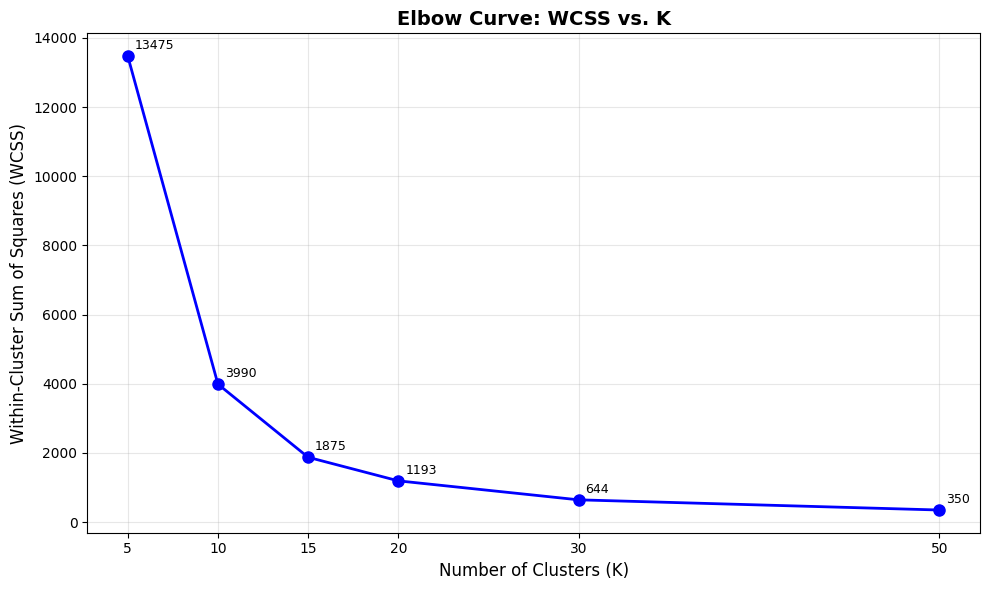

In [12]:
import matplotlib.pyplot as plt
# Extract K values and WCSS for plotting
k_list = list(wcss_values.keys())
wcss_list = list(wcss_values.values())
# Create elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_list, wcss_list, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.title('Elbow Curve: WCSS vs. K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_list)

# Annotate each point
for i, (k, wcss) in enumerate(zip(k_list, wcss_list)):
    plt.annotate(f'{wcss:.0f}', 
                 xy=(k, wcss), 
                 xytext=(5, 5), 
                 textcoords='offset points',
                 fontsize=9)

plt.tight_layout()
plt.show()

         7.4. Calculate Silhouette Score

In [13]:
def silhouette_score_1d(features, labels, k):
    features = features.flatten()  
    n_samples = len(features)
    silhouette_sum = 0

    # Precompute clusters
    clusters = [np.where(labels == c)[0] for c in range(k)]
    
    for i in range(n_samples):
        point = features[i]
        cluster_i = labels[i]

        # Points in same cluster except self
        same_cluster_idx = np.setdiff1d(clusters[cluster_i], [i])
        a_i = np.mean(np.abs(point - features[same_cluster_idx])) if len(same_cluster_idx) > 0 else 0

        # Minimum average distance to other clusters
        b_i = float('inf')
        for c_id in range(k):
            if c_id == cluster_i:
                continue
            other_idx = clusters[c_id]
            if len(other_idx) > 0:
                avg_dist = np.mean(np.abs(point - features[other_idx]))
                if avg_dist < b_i:
                    b_i = avg_dist

        s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0
        silhouette_sum += s_i

        # progress indicator
        if (i + 1) % 10000 == 0:
            print(f"  Processed {i+1}/{n_samples} users...")

    return silhouette_sum / n_samples

In [14]:
silhouette_scores = {}
features = user_feature_vector[['z_score']].values 
for k in k_values:
    print(f"K = {k}:")
    labels = results[k]['labels']  
    score = silhouette_score_1d(features, labels, k)  
    silhouette_scores[k] = score
    print(f"  Final Silhouette Score = {score:.4f}\n")


K = 5:
  Processed 10000/138493 users...
  Processed 20000/138493 users...
  Processed 30000/138493 users...
  Processed 40000/138493 users...
  Processed 50000/138493 users...
  Processed 60000/138493 users...
  Processed 70000/138493 users...
  Processed 80000/138493 users...
  Processed 90000/138493 users...
  Processed 100000/138493 users...
  Processed 110000/138493 users...
  Processed 120000/138493 users...
  Processed 130000/138493 users...
  Final Silhouette Score = 0.5189

K = 10:
  Processed 10000/138493 users...
  Processed 20000/138493 users...
  Processed 30000/138493 users...
  Processed 40000/138493 users...
  Processed 50000/138493 users...
  Processed 60000/138493 users...
  Processed 70000/138493 users...
  Processed 80000/138493 users...
  Processed 90000/138493 users...
  Processed 100000/138493 users...
  Processed 110000/138493 users...
  Processed 120000/138493 users...
  Processed 130000/138493 users...
  Final Silhouette Score = 0.5181

K = 15:
  Processed 100

8. Optimal K analysis

           1. Determine Optimal K (highest silhouette score)

In [15]:
optimal_k = 5  
# Add optimal cluster assignments to dataframe
user_feature_vector['cluster_optimal'] = results[optimal_k]['labels']

               8.1.1. Distribution Bar Chart


Cluster Distribution for K=5:
  Cluster 0:   6481 users ( 4.68%)
  Cluster 1:  43441 users (31.37%)
  Cluster 2:  43307 users (31.27%)
  Cluster 3:  19264 users (13.91%)
  Cluster 4:  26000 users (18.77%)


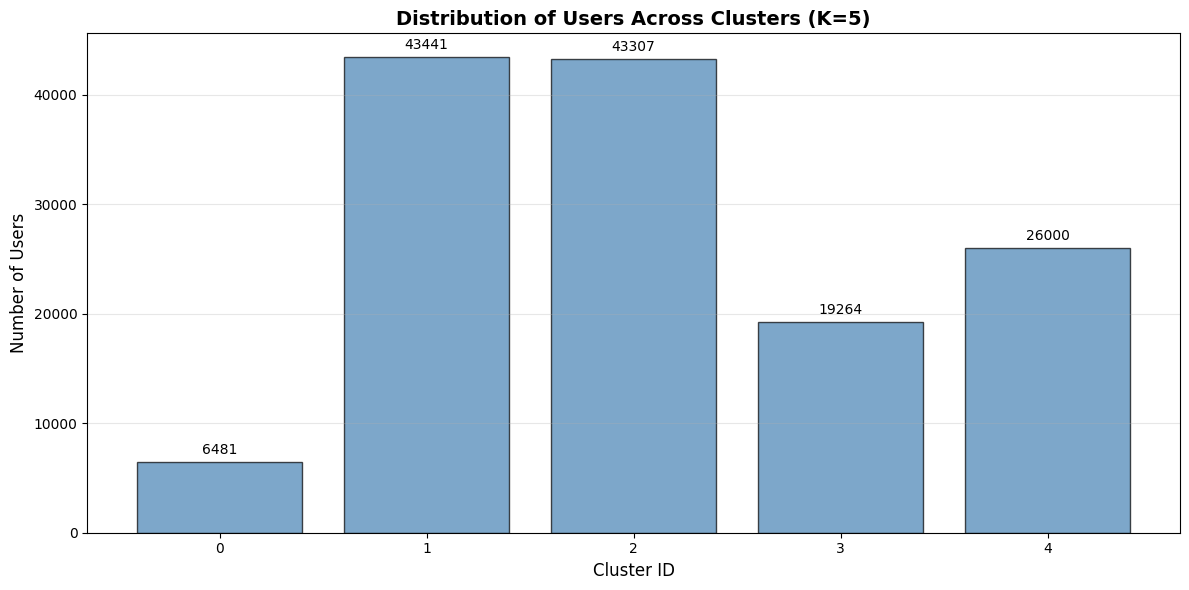

In [16]:
# Count users in each cluster
cluster_ids, cluster_counts = np.unique(results[optimal_k]['labels'], return_counts=True)

# Display counts with percentages
print(f"\nCluster Distribution for K={optimal_k}:")
total_users = cluster_counts.sum()
for i, count in zip(cluster_ids, cluster_counts):
    percentage = (count / total_users) * 100
    print(f"  Cluster {i}: {count:6d} users ({percentage:5.2f}%)")

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(cluster_ids, cluster_counts, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title(f'Distribution of Users Across Clusters (K={optimal_k})', fontsize=14, fontweight='bold')
plt.xticks(cluster_ids)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, count in zip(cluster_ids, cluster_counts):
    plt.text(i, count + max(cluster_counts)*0.01, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


Note: If we took the best K not the optimal (depending on the elbow curve) we will take k=15

          8.2. Average Rating per Cluster centroid

In [17]:
centroids = results[optimal_k]['centroids']
print(f"\nAverage Rating per Cluster Centroid (K={optimal_k}):")
for i in range(optimal_k):
    average_rating_value = centroids[i][0] * std_ru + mean_ru  # convert Z-score to original rating
    print(f"Cluster {i}: {average_rating_value:.4f}")


Average Rating per Cluster Centroid (K=5):
Cluster 0: 2.5757
Cluster 1: 3.8650
Cluster 2: 3.5442
Cluster 3: 4.2386
Cluster 4: 3.1768


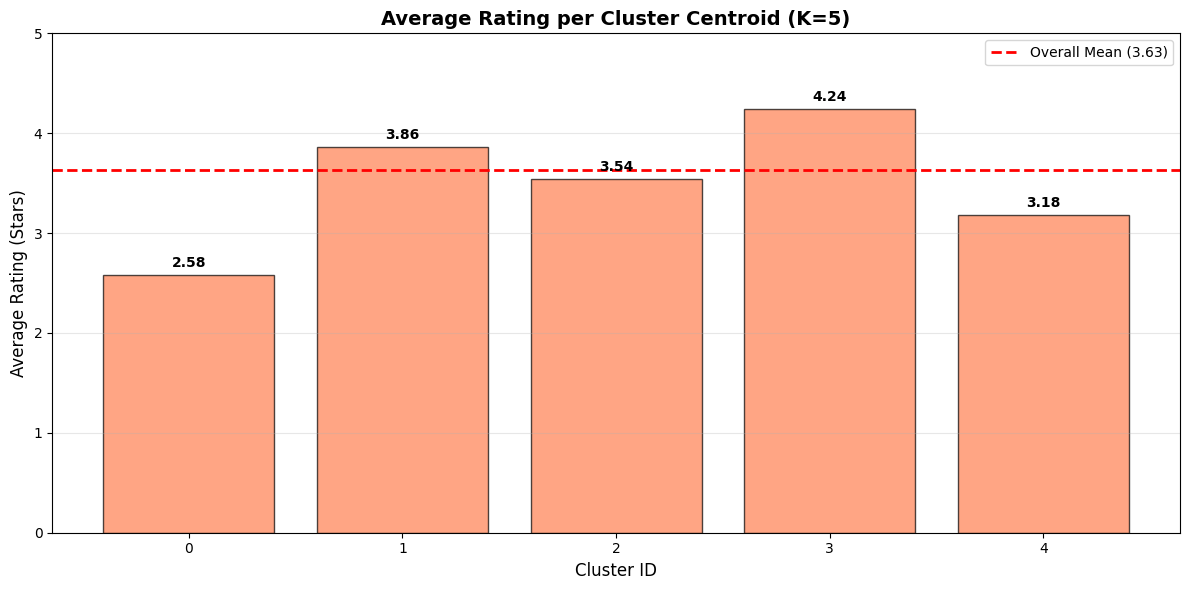

In [18]:
cluster_ids = list(range(optimal_k))
ratings = [centroids[i][0] * std_ru + mean_ru for i in range(optimal_k)]  # average rating per centroid

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(cluster_ids, ratings, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Average Rating (Stars)', fontsize=12)
plt.title(f'Average Rating per Cluster Centroid (K={optimal_k})', fontsize=14, fontweight='bold')
plt.xticks(cluster_ids)
plt.ylim(0, 5)

# Optional: show overall mean rating as a reference line
plt.axhline(y=mean_ru, color='red', linestyle='--', linewidth=2, label=f'Overall Mean ({mean_ru:.2f})')
plt.grid(axis='y', alpha=0.3)
plt.legend()

# Add value labels on top of bars
for i, rating in enumerate(ratings):
    plt.text(i, rating + 0.05, f'{rating:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

            8.3. Identify Generous and Strict Raters

Cluster 0: 2.58 stars → Strict Raters
Cluster 1: 3.86 stars → Generous Raters
Cluster 2: 3.54 stars → Strict Raters
Cluster 3: 4.24 stars → Generous Raters
Cluster 4: 3.18 stars → Strict Raters


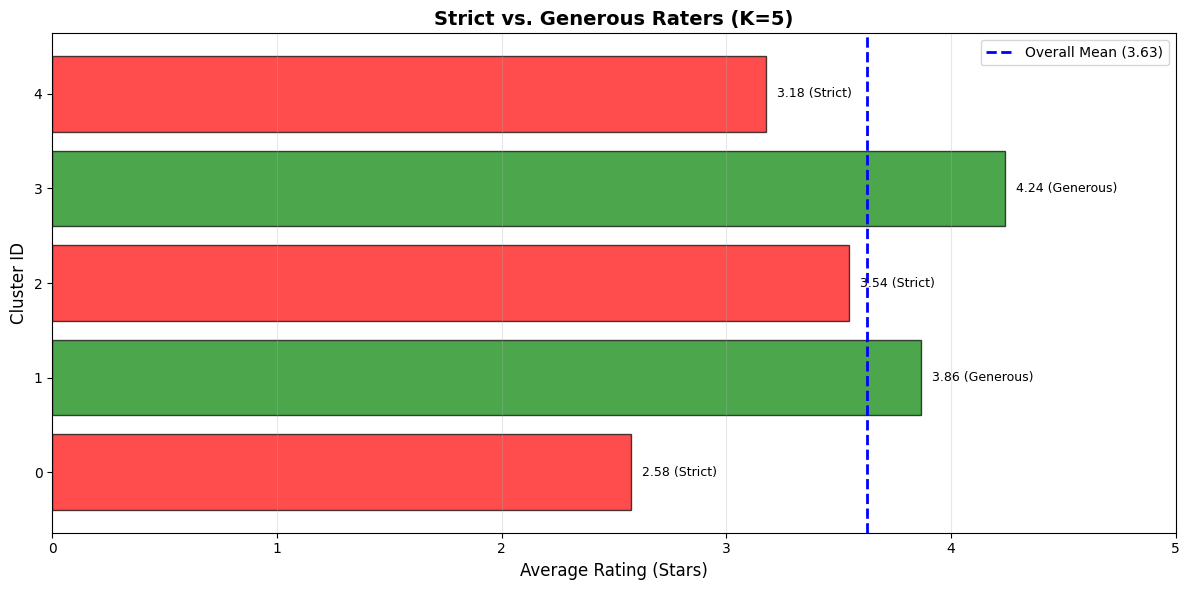

In [19]:
ratings = [centroids[i][0] * std_ru + mean_ru for i in range(optimal_k)]  # average rating per centroid
cluster_ids = list(range(optimal_k))
# Identify strict vs generous clusters
cluster_types = ["Strict" if r < mean_ru else "Generous" for r in ratings]

for cid, r, ctype in zip(cluster_ids, ratings, cluster_types):
    print(f"Cluster {cid}: {r:.2f} stars → {ctype} Raters")

# Visualization
colors = ['red' if r < mean_ru else 'green' for r in ratings]
plt.figure(figsize=(12, 6))
plt.barh(cluster_ids, ratings, color=colors, edgecolor='black', alpha=0.7)
plt.ylabel('Cluster ID', fontsize=12)
plt.xlabel('Average Rating (Stars)', fontsize=12)
plt.title(f'Strict vs. Generous Raters (K={optimal_k})', fontsize=14, fontweight='bold')
plt.axvline(x=mean_ru, color='blue', linestyle='--', linewidth=2, label=f'Overall Mean ({mean_ru:.2f})')
plt.xlim(0, 5)
plt.grid(axis='x', alpha=0.3)
plt.legend()

# Add labels on bars
for cid, r in zip(cluster_ids, ratings):
    label = "Strict" if r < mean_ru else "Generous"
    plt.text(r + 0.05, cid, f'{r:.2f} ({label})', va='center', fontsize=9)

plt.tight_layout()
plt.show()

9. Apply user-based CF on each cluster

             9.1. Identify Target Users' Clusters

In [20]:
target_users_df = pd.read_csv('target_users.csv')
# Extract user IDs
target_users = target_users_df['userId'].tolist()
print("   ")
# Get their cluster assignments (using optimal K) 
target_user_clusters = {}
cluster_data = []  # List to store data for DataFrame
for user_id in target_users:
    # Find user's cluster
    user_row = user_feature_vector[user_feature_vector['userId'] == user_id]
    if len(user_row) > 0:
        cluster_id = user_row['cluster_optimal'].values[0]
        avg_rating = user_row['feature'].values[0]
        target_user_clusters[user_id] = cluster_id
        # Store data for CSV
        cluster_data.append({
            'userId': user_id,
            'cluster': cluster_id,
            'avg_rating': avg_rating
        })
        
        print(f"User {user_id}: Cluster {cluster_id} (avg rating: {avg_rating:.2f})")
    else:
        print(f"User {user_id}: NOT FOUND in dataset")

# Save to CSV
if cluster_data:
    cluster_df = pd.DataFrame(cluster_data)
    cluster_df.to_csv('user_clusters.csv', index=False)
    print(f"\nSaved {len(cluster_data)} user cluster assignments to 'user_clusters.csv'")
else:
    print("\nNo valid user clusters found to save")

   
User 69251: Cluster 0 (avg rating: 2.78)
User 69481: Cluster 4 (avg rating: 3.13)
User 67075: Cluster 0 (avg rating: 2.55)

Saved 3 user cluster assignments to 'user_clusters.csv'


          9.2. Compute User-User Similarity using MCS whithin th assigned cluster

In [21]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
# Load ratings data
ratings = pd.read_csv("ratings.csv")
# Encode userId and movieId to make rating matrix
user_enc = LabelEncoder()
item_enc = LabelEncoder()
ratings['user_enc'] = user_enc.fit_transform(ratings['userId'])
ratings['item_enc'] = item_enc.fit_transform(ratings['movieId'])
n_users = ratings['user_enc'].nunique()
n_items = ratings['item_enc'].nunique()
# Build sparse user–item matrix
rows = ratings['user_enc'].values
cols = ratings['item_enc'].values
vals = ratings['rating'].values
R = csr_matrix((vals, (rows, cols)), shape=(n_users, n_items))

In [22]:
# Load ALL cluster assignments from user_feature_vector
try:
    clusters = user_feature_vector[['userId', 'cluster_optimal']].copy()
    clusters.rename(columns={'cluster_optimal': 'cluster'}, inplace=True)
except NameError:
    print("\nuser_feature_vector not found, trying to load from CSV...")
    try:
        clusters = pd.read_csv("all_user_clusters.csv")
        print("Loaded all_user_clusters.csv successfully")
    except FileNotFoundError:
        clusters = pd.read_csv("user_clusters.csv")

# Add encoded user IDs to clusters dataframe
clusters['user_enc'] = user_enc.transform(clusters['userId'])

# Create dictionary: user_enc to cluster
clusters_dict = dict(zip(clusters['user_enc'], clusters['cluster']))

# Load target users
targets = pd.read_csv("target_users.csv")
# Add encoded ID
targets['user_enc'] = user_enc.transform(targets['userId'])
print(targets)

  User  userId  user_enc
0   U1   69251     69250
1   U2   69481     69480
2   U3   67075     67074


In [23]:
def cosine_similarity(vector1, vector2):
    # Convert to dense arrays
    v1 = vector1.toarray().flatten()
    v2 = vector2.toarray().flatten()
    
    # Compute dot product
    dot_product = 0.0
    for i in range(len(v1)):
        dot_product += v1[i] * v2[i]
    
    # Compute norms (magnitudes)
    norm1 = 0.0
    for i in range(len(v1)):
        norm1 += v1[i] ** 2
    norm1 = norm1 ** 0.5
    
    norm2 = 0.0
    for i in range(len(v2)):
        norm2 += v2[i] ** 2
    norm2 = norm2 ** 0.5
    
    # Avoid division by zero
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    similarity = dot_product / (norm1 * norm2)
    return similarity


def mean_centered_cosine_similarity_cluster(target_user_enc):
    # User's cluster
    cluster_id = clusters_dict[target_user_enc]
    
    # Users in same cluster
    cluster_users = clusters[clusters['cluster'] == cluster_id]['user_enc'].values
    
    print(f"  Processing cluster {cluster_id} with {len(cluster_users)} users")
    
    # Extract their rating vectors
    cluster_matrix = R[cluster_users]
    
    # Mean-center each user
    means = cluster_matrix.mean(axis=1).A.flatten()
    centered_matrix = cluster_matrix.copy().astype(float)
    
    for i, m in enumerate(means):
        if m != 0:
            # Subtract mean from all ratings of this user
            start = centered_matrix.indptr[i]
            end = centered_matrix.indptr[i+1]
            centered_matrix.data[start:end] -= m
    
    # Find target user's index in the cluster
    target_index = np.where(cluster_users == target_user_enc)[0][0]
    target_vector = centered_matrix[target_index]
    
    # Compute cosine similarity manually for each user in cluster
    similarities = []
    
    for i in range(len(cluster_users)):
        if i == target_index:
            # Exclude self
            similarities.append(-1)
        else:
            # Compute similarity manually
            sim = cosine_similarity(target_vector, centered_matrix[i])
            similarities.append(sim)
        
       
    similarities = np.array(similarities)
    
    return cluster_users, similarities, cluster_id


# Run for each target user
all_results = []

for _, row in targets.iterrows():
    user_enc_id = row['user_enc']
    user_id = row['userId']
    
    print(f"Mean-Centered Cosine Similarity for User {user_id}")
    
    cluster_users, sims, cluster_id = mean_centered_cosine_similarity_cluster(user_enc_id)
    
    print(f"User {user_id} is in Cluster {cluster_id}")
    print(f"Cluster contains {len(cluster_users)} users")
    
    # Show top 5 most similar users
    top10_idx = sims.argsort()[::-1][:5]
    
    print(f"\nTop 10 similar users (within same cluster):")
    print(f"{'Rank':<6} {'User ID':<12} {'User_Enc':<12} {'Similarity':<12}")
    
    for rank, idx in enumerate(top10_idx, 1):
        similar_user_enc = cluster_users[idx]
        similar_user_id = user_enc.inverse_transform([similar_user_enc])[0]
        similarity = sims[idx]
        
        print(f"{rank:<6} {similar_user_id:<12} {similar_user_enc:<12} {similarity:<12.4f}")
        
        # Store for CSV
        all_results.append({
            'target_userId': user_id,
            'target_user_enc': user_enc_id,
            'similar_userId': similar_user_id,
            'similar_user_enc': similar_user_enc,
            'rank': rank,
            'similarity': similarity,
            'cluster': cluster_id
        })

# Save results to CSV
results_df = pd.DataFrame(all_results)
results_df.to_csv('user_similarities_manual.csv', index=False)

Mean-Centered Cosine Similarity for User 69251
  Processing cluster 0 with 6481 users
User 69251 is in Cluster 0
Cluster contains 6481 users

Top 10 similar users (within same cluster):
Rank   User ID      User_Enc     Similarity  
1      19399        19398        0.3525      
2      62621        62620        0.3345      
3      38351        38350        0.3245      
4      106015       106014       0.3219      
5      18972        18971        0.3108      
Mean-Centered Cosine Similarity for User 69481
  Processing cluster 4 with 26000 users
User 69481 is in Cluster 4
Cluster contains 26000 users

Top 10 similar users (within same cluster):
Rank   User ID      User_Enc     Similarity  
1      87746        87745        0.5263      
2      94259        94258        0.4978      
3      55286        55285        0.4954      
4      93920        93919        0.4952      
5      79662        79661        0.4917      
Mean-Centered Cosine Similarity for User 67075
  Processing cluster 0 with

             9.3  Select the top 20% most similar users from within the same cluster

In [24]:
top_20_percent_results = []

for _, row in targets.iterrows():
    user_id = row['userId']
    user_enc_id = row['user_enc']
    
    # Get similarities and cluster ID
    cluster_users_enc, sims, cluster_id = mean_centered_cosine_similarity_cluster(user_enc_id)
    n_top = max(1, int(len(sims) * 0.2))  # top 20%
    top_indices = sims.argsort()[::-1][:n_top]

    print(f"\nUser {user_id} (Cluster {cluster_id})")
    print(f"Total users in cluster: {len(cluster_users_enc)}")
    print(f"Top 20% = {n_top} users")
    
    print(f"\nTop 20% most similar users:")
    print(f"{'Rank':<6} {'User ID':<12} {'User_Enc':<12} {'Similarity':<12}")

    for rank, idx in enumerate(top_indices, 1):
        similar_user_enc = cluster_users_enc[idx]
        similar_user_id = user_enc.inverse_transform([similar_user_enc])[0]
        similarity = sims[idx]
        
        # Print first 10 users only
        if rank <= 10:
            print(f"{rank:<6} {similar_user_id:<12} {similar_user_enc:<12} {similarity:<12.4f}")
        elif rank == 11:
            print(f"and {n_top - 10} more users")
        
        # Append results
        top_20_percent_results.append({
            'target_userId': user_id,
            'target_user_enc': user_enc_id,
            'similar_userId': similar_user_id,
            'similar_user_enc': similar_user_enc,
            'rank': rank,
            'similarity': similarity,
            'cluster': cluster_id,
            'percentile': 'top_20'
        })

# Save to CSV
pd.DataFrame(top_20_percent_results).to_csv('user_similarities_top20.csv', index=False)


  Processing cluster 0 with 6481 users

User 69251 (Cluster 0)
Total users in cluster: 6481
Top 20% = 1296 users

Top 20% most similar users:
Rank   User ID      User_Enc     Similarity  
1      19399        19398        0.3525      
2      62621        62620        0.3345      
3      38351        38350        0.3245      
4      106015       106014       0.3219      
5      18972        18971        0.3108      
6      52574        52573        0.3084      
7      95194        95193        0.3082      
8      108405       108404       0.3015      
9      61506        61505        0.2928      
10     129344       129343       0.2919      
and 1286 more users
  Processing cluster 4 with 26000 users

User 69481 (Cluster 4)
Total users in cluster: 26000
Top 20% = 5200 users

Top 20% most similar users:
Rank   User ID      User_Enc     Similarity  
1      87746        87745        0.5263      
2      94259        94258        0.4978      
3      55286        55285        0.4954      
4   

       9.4 Predict ratings for the target items (I1 and I2 and I3) using only the similar users from the same cluster

In [25]:
# Load target items
target_items = pd.read_csv("target_items.csv")
if 'itemId' in target_items.columns:
    item_ids = target_items['itemId'].tolist()
elif 'movieId' in target_items.columns:
    item_ids = target_items['movieId'].tolist()
elif 'Item' in target_items.columns:
    item_ids = target_items['Item'].tolist()
else:
    item_ids = target_items.iloc[:, 0].tolist()

# Convert precomputed top 20% results into a dictionary for fast lookup
from collections import defaultdict
top_users_dict = defaultdict(list)
for row in top_20_percent_results:
    target_user_enc = row['target_user_enc']
    similar_user_enc = row['similar_user_enc']
    top_users_dict[target_user_enc].append(similar_user_enc)

# Generate predictions
predictions = {}
for _, row in targets.iterrows():
    user_id = row['userId']
    user_enc_id = row['user_enc']
    
    if user_enc_id not in top_users_dict:
        continue  
    
    top_users_enc = np.array(top_users_dict[user_enc_id])
    
    # Target user's mean rating
    target_user_ratings = R[user_enc_id].data
    target_user_mean = target_user_ratings.mean() if len(target_user_ratings) > 0 else 3.0
    
    user_preds = {}
    for item_id in item_ids:
        if item_id not in item_enc.classes_:
            continue
        
        item_enc_id = item_enc.transform([item_id])[0]
        
        # Ratings of top similar users
        ratings_top = R[top_users_enc, item_enc_id].toarray().flatten()
        means_top = np.array([R[u].data.mean() if R[u].nnz > 0 else 3.0 for u in top_users_enc])
        
        mask = ratings_top != 0
        if mask.sum() > 0:
            ratings_centered = ratings_top[mask] - means_top[mask]
            pred = np.clip(ratings_centered.mean() + target_user_mean, 0.5, 5.0)
        else:
            pred = target_user_mean
        
        # Clip to valid range
        pred = np.clip(pred, 0.5, 5.0)
        pred = int(round(pred))
        user_preds[item_id] = pred
    
    predictions[user_id] = user_preds

# Display predictions
for user_id, preds in predictions.items():
    print(f"\nUser {user_id} predictions:")
    for item_id, rating in preds.items():
        print(f"  {item_id}: {rating:.2f}")



User 69251 predictions:
  116181: 3.00
  106503: 3.00
  8860: 2.00

User 69481 predictions:
  116181: 3.00
  106503: 3.00
  8860: 3.00

User 67075 predictions:
  116181: 2.00
  106503: 1.00
  8860: 2.00


fallback = no similar users rated this

11. Analyze computatioal effeciency gains 

            11.1 calculate number of similaity computations needed without clustering

In [26]:
computations_without_clustering = (total_users * (total_users - 1)) / 2
print(f"\nWithout clustering, we compare ALL user pairs:")
print(f"  Formula: C(n, 2) = n × (n - 1) / 2")
print(f"  Computations: {total_users:,} × {total_users - 1:,} / 2")
print(f"  Total: {computations_without_clustering:,.0f} similarity computations")


Without clustering, we compare ALL user pairs:
  Formula: C(n, 2) = n × (n - 1) / 2
  Computations: 138,493 × 138,492 / 2
  Total: 9,590,086,278 similarity computations


            11.2 calculate number of similaity computations needed with clustering

In [27]:
print(f"\nUsing K = {optimal_k} clusters")
# Get cluster sizes
cluster_sizes = user_feature_vector['cluster_optimal'].value_counts().sort_index()
computations_per_cluster = []
total_computations_with_clustering = 0
print(f"{'Cluster':<10} {'Size':<10} {'Computations':<20}")

for cluster_id in range(optimal_k):
    cluster_size = cluster_sizes.get(cluster_id, 0)
    
    # Within each cluster: C(cluster_size, 2) = cluster_size * (cluster_size - 1) / 2
    cluster_computations = (cluster_size * (cluster_size - 1)) / 2
    
    computations_per_cluster.append(cluster_computations)
    total_computations_with_clustering += cluster_computations
    
    print(f"{cluster_id:<10} {cluster_size:<10} {cluster_computations:<20,.0f}")

print("  ")
print(f"{'TOTAL':<10} {total_users:<10} {total_computations_with_clustering:<20,.0f}")


Using K = 5 clusters
Cluster    Size       Computations        
0          6481       20,998,440          
1          43441      943,538,520         
2          43307      937,726,471         
3          19264      185,541,216         
4          26000      337,987,000         
  
TOTAL      138493     2,425,791,647       


             11.3 Computer the speed factor

In [28]:
speedup_factor = computations_without_clustering / total_computations_with_clustering
print(f"\nSpeedup Factor = Computations without clustering / Computations with clustering")
print(f"               = {computations_without_clustering:,.0f} / {total_computations_with_clustering:,.0f}")
print(f"               = {speedup_factor:.2f}x")
print(f"\n Clustering provides a {speedup_factor:.2f}x speedup")


Speedup Factor = Computations without clustering / Computations with clustering
               = 9,590,086,278 / 2,425,791,647
               = 3.95x

 Clustering provides a 3.95x speedup


                11.4 Effeciency gain as precentage

In [29]:
reduction = computations_without_clustering - total_computations_with_clustering
percentage_reduction = (reduction / computations_without_clustering) * 100

print(f"\nReduction in computations = {reduction:,.0f}")
print(f"Percentage reduction = (Reduction / Original) × 100")
print(f"                     = ({reduction:,.0f} / {computations_without_clustering:,.0f}) × 100")
print(f"                     = {percentage_reduction:.2f}%")
print(f"\n Clustering reduces similarity computations by {percentage_reduction:.2f}%")


Reduction in computations = 7,164,294,631
Percentage reduction = (Reduction / Original) × 100
                     = (7,164,294,631 / 9,590,086,278) × 100
                     = 74.71%

 Clustering reduces similarity computations by 74.71%


12. Evaluate the impact of cluster imbalance

        12.1 Identify Cluster Imbalance

In [30]:
# Calculate ideal cluster size
ideal_size = total_users / optimal_k

print(f"\nTotal Users: {total_users:,}")
print(f"Number of Clusters (K): {optimal_k}")
print(f"Ideal Size per Cluster: {ideal_size:,.0f} users ({100/optimal_k:.1f}%)")
print(f"\n{'Cluster':<10} {'Size':<12} {'% of Total':<12} {'Deviation':<15} {'Status'}")

# Categorize clusters
very_large = []
large = []
balanced = []
small = []
very_small = []
empty = []

for cluster_id in range(optimal_k):
    size = cluster_counts.get(cluster_id, 0)
    percentage = (size / total_users) * 100
    deviation = ((size - ideal_size) / ideal_size) * 100
    
    # Categorize for better understanding
    if size == 0:
        status = "empty"
        empty.append(cluster_id)
    elif size > ideal_size * 2.5:
        status = "v large"
        very_large.append(cluster_id)
    elif size > ideal_size * 1.5:
        status = "large"
        large.append(cluster_id)
    elif size < ideal_size * 0.3:
        status = "v small"
        very_small.append(cluster_id)
    elif size < ideal_size * 0.7:
        status = "small"
        small.append(cluster_id)
    else:
        status = "balanced"
        balanced.append(cluster_id)
    
    print(f"{cluster_id:<10} {size:<12,} {percentage:<11.2f}% {deviation:>+13.1f}% {status}")

print(f"{'TOTAL':<10} {total_users:<12,} {100.0:<11.2f}%")



Total Users: 138,493
Number of Clusters (K): 5
Ideal Size per Cluster: 27,699 users (20.0%)

Cluster    Size         % of Total   Deviation       Status


AttributeError: 'numpy.ndarray' object has no attribute 'get'

            12.2 how cluster imbalance effect the computational effeciency

In [ ]:
# Computational Cost Analysis
actual_computations = sum(size * (size - 1) / 2 for size in cluster_counts)
ideal_computations = optimal_k * (ideal_size * (ideal_size - 1) / 2)

print(f"Balanced clusters ({ideal_size:,.0f} users each):")
print(f"  Per cluster: {(ideal_size * (ideal_size - 1) / 2):,.0f}")
print(f"  Total:       {ideal_computations:,.0f}")

print(f"\nActual imbalanced clusters:")
print(f"  Total:       {actual_computations:,.0f}")

efficiency_loss = (actual_computations - ideal_computations) / ideal_computations * 100
print(f"\nEfficiency Loss due to imbalance: {efficiency_loss:.1f}%")

# Impact of largest cluster
largest_cluster = max(cluster_counts)
largest_cluster_comps = largest_cluster * (largest_cluster - 1) / 2
largest_cluster_pct = largest_cluster_comps / actual_computations * 100

print(f"\nLargest cluster (size: {largest_cluster:,}):")
print(f"  Computations: {largest_cluster_comps:,.0f}")
print(f"  % of total:   {largest_cluster_pct:.1f}%")

# Splitting largest cluster
split_size = largest_cluster / 3
split_comps = 3 * (split_size * (split_size - 1) / 2)
savings = (largest_cluster_comps - split_comps) / largest_cluster_comps * 100

print(f"\nIf split into 3 balanced clusters:")
print(f"  3 clusters of {split_size:,.0f} each")
print(f"  Computations: {split_comps:,.0f}")
print(f"  Savings: {savings:.1f}%")

# speedup
without_clustering = total_users * (total_users - 1) / 2
actual_speedup = without_clustering / actual_computations
ideal_speedup = without_clustering / ideal_computations

print(f"\nActual speedup (with imbalance):  {actual_speedup:.2f}x")
print(f"Ideal speedup (balanced clusters): {ideal_speedup:.2f}x")
print(f"Lost potential:                   {ideal_speedup - actual_speedup:.2f}x")
print(f"Efficiency achieved:              {(actual_speedup / ideal_speedup) * 100:.1f}% of optimal")


Balanced clusters (27,699 users each):
  Per cluster: 383,592,372
  Total:       1,917,961,858

Actual imbalanced clusters:
  Total:       2,425,791,647

Efficiency Loss due to imbalance: 26.5%

Largest cluster (size: 43,441):
  Computations: 943,538,520
  % of total:   38.9%

If split into 3 balanced clusters:
  3 clusters of 14,480 each
  Computations: 314,498,360
  Savings: 66.7%

Actual speedup (with imbalance):  3.95x
Ideal speedup (balanced clusters): 5.00x
Lost potential:                   1.05x
Efficiency achieved:              79.1% of optimal


             12.3 - Strategies to Handle Imbalance  ----> in the report

13. Test reboustness of clustering approach

          13.1 Re-run K-Means with different random initializations

In [ ]:
def kmeans(features, k, max_iters=100, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    n_samples = features.shape[0]
    # Step 1: Initialize centroids randomly from the data points
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = features[random_indices].copy()
    for iteration in range(max_iters):
        # Step 2: Assign each point to nearest centroid
        # Calculate distances from each point to each centroid
        distances = np.zeros((n_samples, k))
        for i in range(k):
            # Euclidean distance
            distances[:, i] = np.sqrt(np.sum((features - centroids[i])**2, axis=1))
        
        # Assign to nearest centroid
        labels = np.argmin(distances, axis=1)
        
        # Step 3: Update centroids
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = features[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                # If cluster is empty, reinitialize to random point as the new centroid
                new_centroids[i] = features[np.random.choice(n_samples)]
        
        # Step 4: Check for convergence
        centroid_shift = np.sqrt(np.sum((new_centroids - centroids)**2))
        centroids = new_centroids
        if centroid_shift < tol:
            print(f"  Converged at iteration {iteration + 1}")
            break
    
    # Calculate sum of squared distances to nearest centroid
    inertia = 0
    for i in range(n_samples):
        inertia += np.sum((features[i] - centroids[labels[i]])**2)
    return centroids, labels, inertia

features = user_feature_vector[['z_score']].values

# Features: only the z_score of users
features = user_feature_vector[['z_score']].values
k = 5  # same as your chosen optimal K

# Run 1
centroids1, labels1, inertia1 = kmeans(features, k, max_iters=100, random_state=42)
# Run 2
centroids2, labels2, inertia2 = kmeans(features, k, max_iters=100, random_state=101)
# Run 3
centroids3, labels3, inertia3 = kmeans(features, k, max_iters=100, random_state=202)

print("K-Means completed 3 runs with different random initializations.")


  Converged at iteration 47
  Converged at iteration 57
  Converged at iteration 54
K-Means completed 3 runs with different random initializations.


          13.2 Compare cluster assignments across runs

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Compare cluster assignments between runs
ari_1_2 = adjusted_rand_score(labels1, labels2)
ari_1_3 = adjusted_rand_score(labels1, labels3)
ari_2_3 = adjusted_rand_score(labels2, labels3)

print("Adjusted Rand Index between runs:")
print(f"Run 1 vs Run 2: {ari_1_2:.4f}")
print(f"Run 1 vs Run 3: {ari_1_3:.4f}")
print(f"Run 2 vs Run 3: {ari_2_3:.4f}")


Adjusted Rand Index between runs:
Run 1 vs Run 2: 1.0000
Run 1 vs Run 3: 1.0000
Run 2 vs Run 3: 1.0000


           13.3 Discuss whether the clustering is stable or varies significantly ---> in the report